To run this example, install the tumor2d package available here:
[Agent-based 2D Tumor growth model](https://github.com/ICB-DCM/tumor2d).
For details on the model, see
<a href="http://www.cell.com/cell-systems/abstract/S2405-4712(16)30412-4">Jagiella, Rickert, Theis, Hasenauer (2017)</a>.
(Note that the tumor2d package is not part of the paper by Jagiella, Rickert, Theis, Hasenauer 2017, but was specifically developed and adapted for pyABC, however based on the original source code).

Briefly, the model is a multi-scale model describing the growth of a 2D tumor spheroid (see animations below). It is a hybrid discrete-continuum model which exploits an agent-based description for individual calls and a PDE-based description for the extracellular matrix. The intra-cellular mechanism of cell-division is described by continuous-time Markov chains and decision rules. In particular the initial phase of the growth is substantially stochastic. During the later phases, with higher cell numbers, averaging effects occur.

The proliferating cells are depicted in orange

![Proliferation](t2danimation/dividing_bg_transparent.gif)

Extracellular matrix intensity is coded in the intensity of the green color

![Extracellular matrix](t2danimation/ecm_bg_transparent.gif)

To simulate a growing spheroid, we employ the simulate function provided by the tumor2d package.

In [1]:
from time import time
from tumor2d import simulate

start_time = time()
observation = simulate(division_rate=4.17e-2,
                       initial_spheroid_radius=1.2e1,
                       initial_quiescent_cell_fraction=7.5e-1,
                       division_depth=100,
                       ecm_production_rate=5e-3,
                       ecm_degradation_rate=8e-4,
                       ecm_division_threshold=1e-2)
print(f"Simulation took {time() - start_time:.2f}s")

Simulation took 44.47s


The simulation took a little time.
The simulate function does not return each individual cell.
Instead, we "measure" the radial density of proliferating cells, the radial extracellular matrix density and the spheroid radius over time.
These statistics summarize the underlying data.

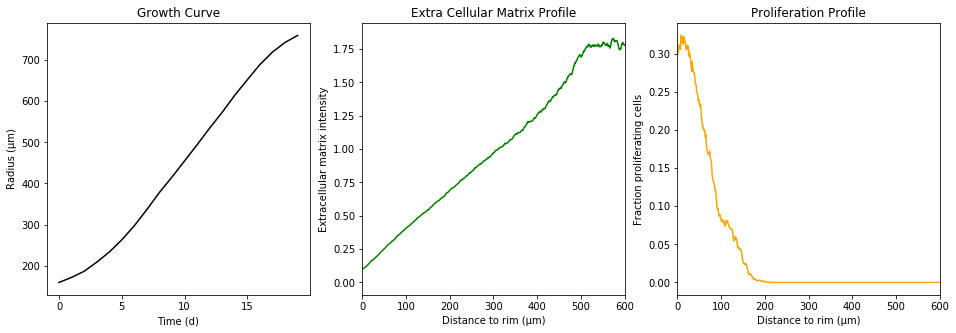

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from string import capwords

fig, axes = plt.subplots(ncols=3)
fig.set_size_inches((16, 5))

color = {"growth_curve":
             "k",
         "extra_cellular_matrix_profile":
             "green",
         "proliferation_profile":
             "orange"}

x_label = {"growth_curve":
               "Time (d)",
           "extra_cellular_matrix_profile":
               "Distance to rim (μm)",
           "proliferation_profile":
               "Distance to rim (μm)"}

y_label = {"growth_curve":
               "Radius (μm)",
           "extra_cellular_matrix_profile":
               "Extracellular matrix intensity",
           "proliferation_profile":
               "Fraction proliferating cells"}

for ax, (key, val) in zip(axes, observation.items()):
    ax.plot(val, color=color[key])
    ax.set_title(capwords(key.replace("_", " ")))
    ax.set_xlabel(x_label[key])
    ax.set_ylabel(y_label[key])
    if key.endswith("profile"):
        ax.set_xlim(0, 600)

To perform parameter inference with pyABC, we first define a prior over the seven parameters.
We do this on the log-domain.

In [3]:
from pyabc import Distribution, RV

limits = dict(log_division_rate=(-3, -1),
              log_division_depth=(1, 3),
              log_initial_spheroid_radius=(0, 1.2),
              log_initial_quiescent_cell_fraction=(-5, 0),
              log_ecm_production_rate=(-5, 0),
              log_ecm_degradation_rate=(-5, 0),
              log_ecm_division_threshold=(-5, 0))

prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

Note that we define the ``limits`` dictionary for later visualization usages and then initialize the prior indirectly to not to repeat ourselves.

Each spheroid simulation runs already in its own subprocess, which is forked off from the main process by the simulate function.
We therefore do not need to parallelize using multiprocessing, but will instead use multithreading.
pyABC ships with a flexible sampler which accepts any backend implementing the ``concurrent.futures.Executor`` interface.
For instance, we can use the ``ThreadPoolExecutor``.
For distributed execution the IPython parallel client would be an alternative, but the ``ThreadPoolExecutor`` is good enough for illustrative purposes.

Since we've defined the priors on the log domain, we also use a model accepting log-transformed parameters. This model is defined as ``tumor2d.log_model``.
It is a thin wrapper around the ``tumor2d.simulate`` function and transforms the parameters accordingly before executing the simulate function.

The tumor2d package also provides a distance function and default data.
These data were obtained from 100 samples from the so called "reference parameters", which we also used above to simulate one growing spheroid.
We takte the mean from these 100 simulations as the observed data.
The distance function calculates $L_2$ norms for each of the three summary statistics and adds them up.
(These $L_2$ norms are normalized by the pointwise variances.)

In [4]:
from tumor2d import log_model, distance, load_default
from pyabc import ABCSMC
from pyabc.sampler import ConcurrentFutureSampler
from concurrent.futures import ThreadPoolExecutor

data_mean = load_default()[1]  # (raw, mean, var)

pool = ThreadPoolExecutor(max_workers=2)
sampler = ConcurrentFutureSampler(pool)

abc = ABCSMC(log_model, prior, distance,
             population_size=3,
             sampler=sampler)

As usually, we initialize a new ABC inference run with the ``new`` method.

In [5]:
abc.new("sqlite:////tmp/test.db", data_mean)

INFO:Epsilon:initial epsilon is 22475302.127764516
INFO:History:Start <ABCSMC(id=30, start_time=2017-09-18 16:08:43.672062, end_time=None)>


30

Since the inference would run very long on a single local machine, we sample only a single population for illustration purposes.
Note, that we've also set the number of particles to a very small number.
This is much too low for a real inference run, but serves here for illustration purposes and saves sampling time.

In [6]:
history = abc.run(max_nr_populations=1, minimum_epsilon=0)

INFO:ABC:t:0 eps:22475302.1278
INFO:History:Done <ABCSMC(id=30, start_time=2017-09-18 16:08:43.672062, end_time=2017-09-18 16:09:38.154959)>


We visualize the first populatoin with pyABC's ``plot_kde_matrix`` function.

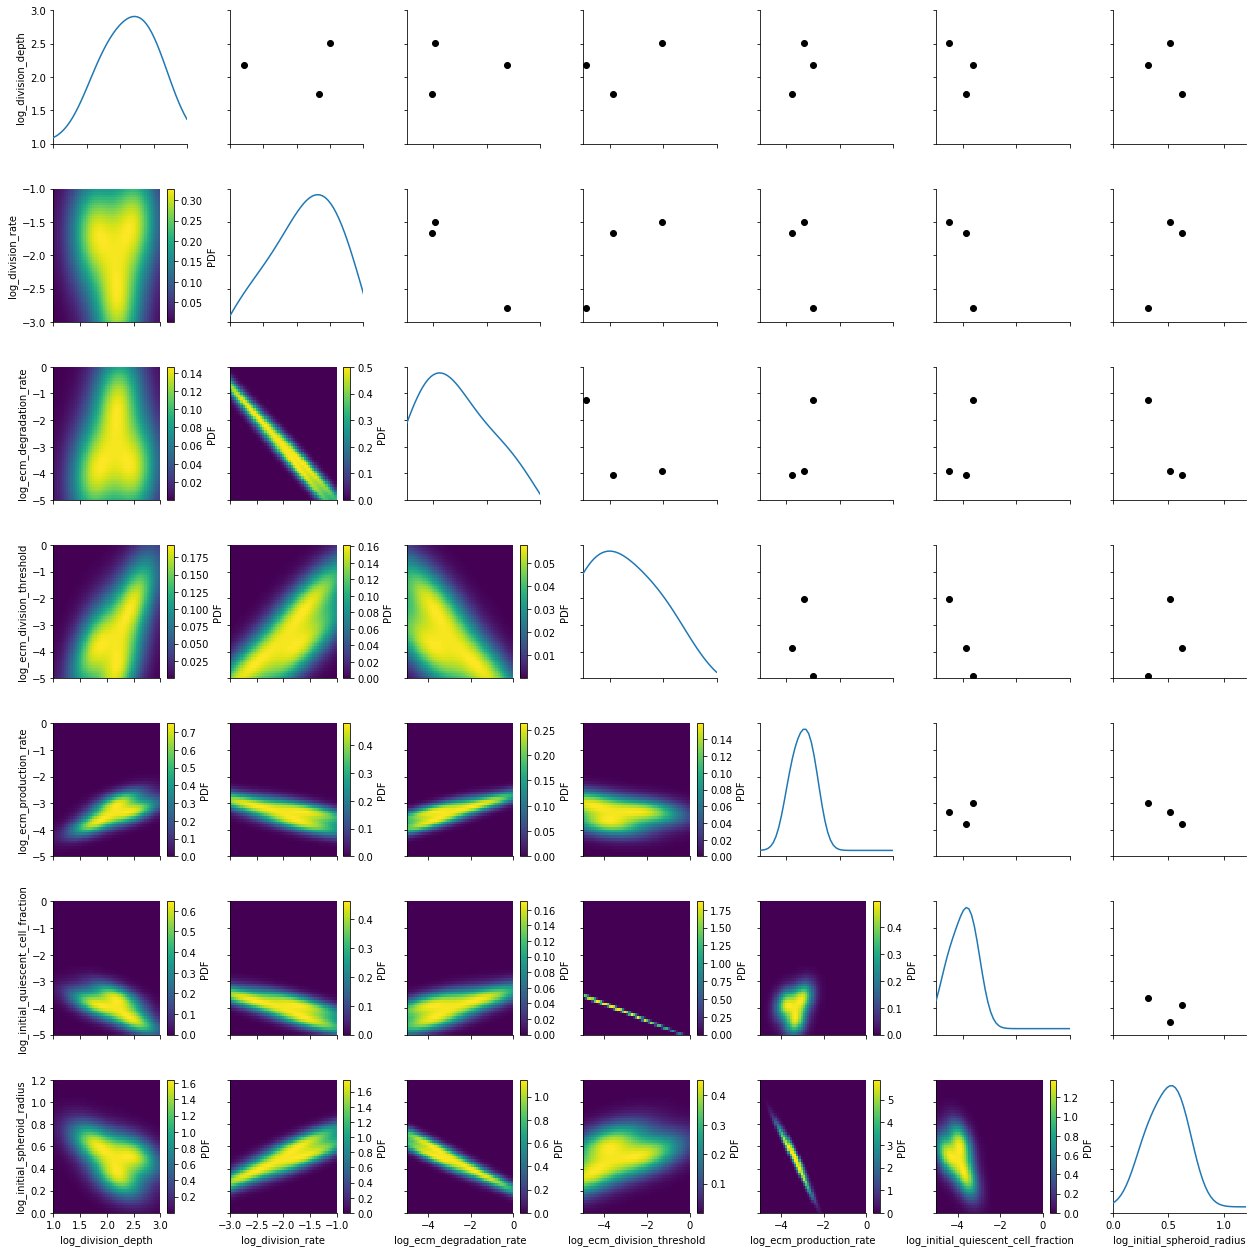

In [7]:
from pyabc.visualization import plot_kde_matrix

df, w = history.get_distribution(m=0)
plot_kde_matrix(df, w, limits=limits);

We see kernel density estimates on the lower diagonal and scatter plots of the weighted particles on the upper diagonal.
Note that the weight of the particles is not encoded in the scatter plots.
On the diagonal we see the marginal distributions.

We've run the inference described above in a distributed fashion on one of our clusters on about 800 cores simultaneously.
The stored data is provided as part of the tumor2d package.
(Note, that the summary statistics were actually also stored in the database. However, to not to distribute a 200MB database, we deleted them afterwards. So they are not contained in the databases distributed with the tumor2d package. If you're interested in the full database, don't hesitate to contact us)

We load the stored database and visualize generation 5.

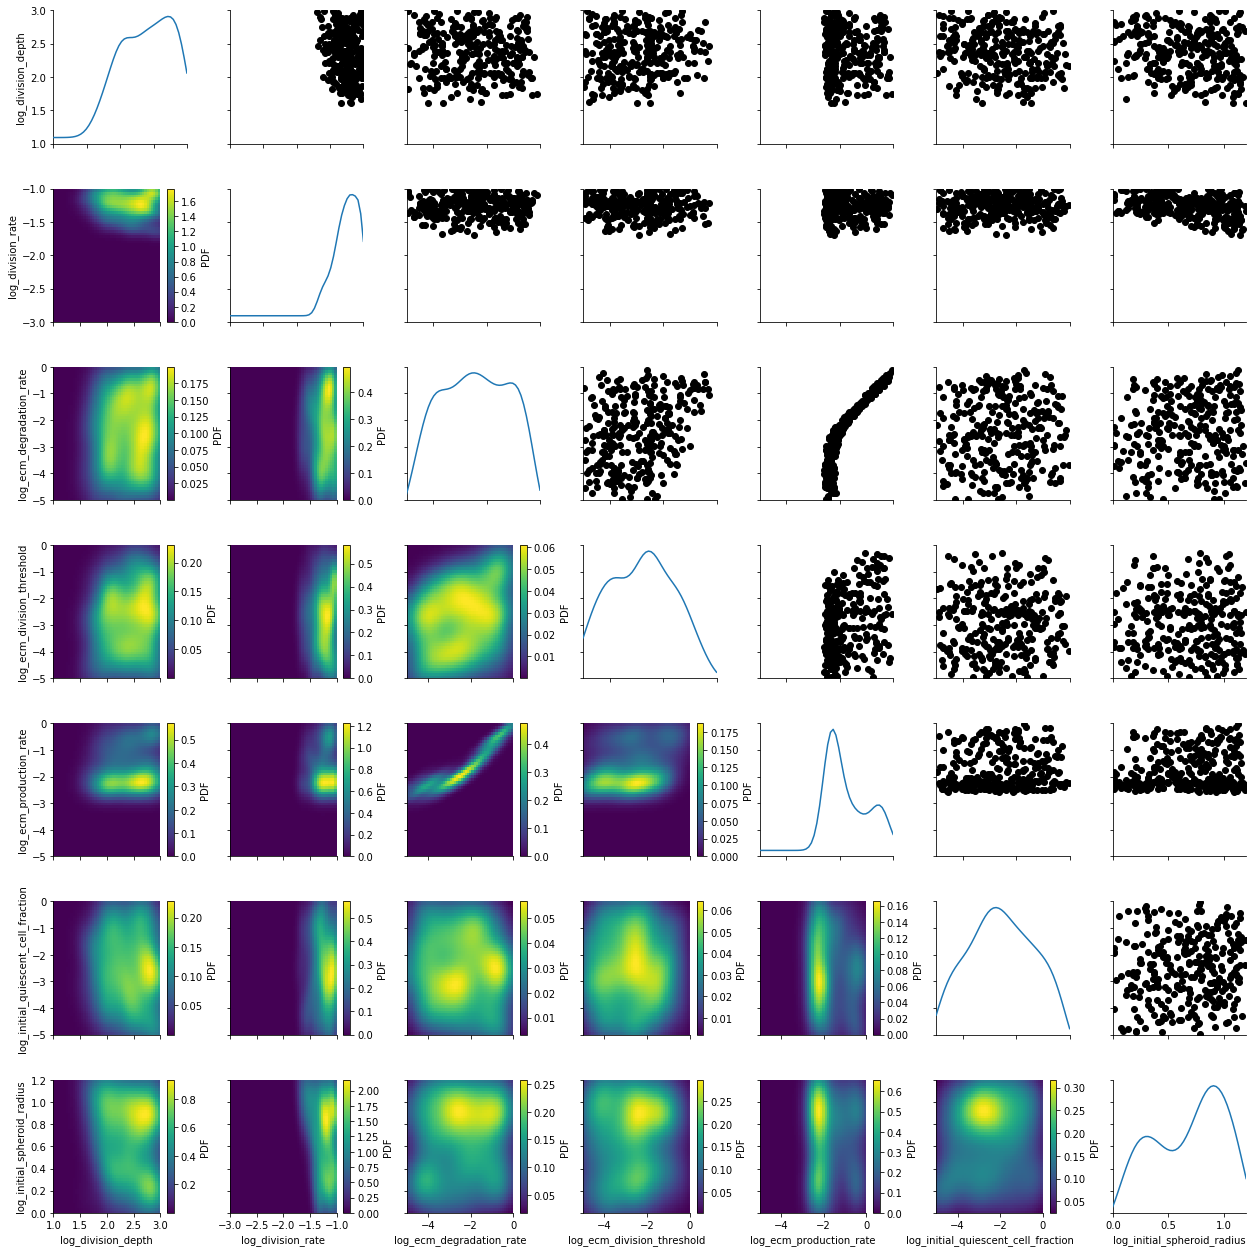

In [8]:
from pyabc import History
from tumor2d import stored_data_db

h_loaded = History("sqlite:///" + stored_data_db)

df, w = h_loaded.get_distribution(m=0, t=5)
plot_kde_matrix(df, w, limits=limits);

The posterior is still quite broad. At the last generation the posterior is notably sharper:

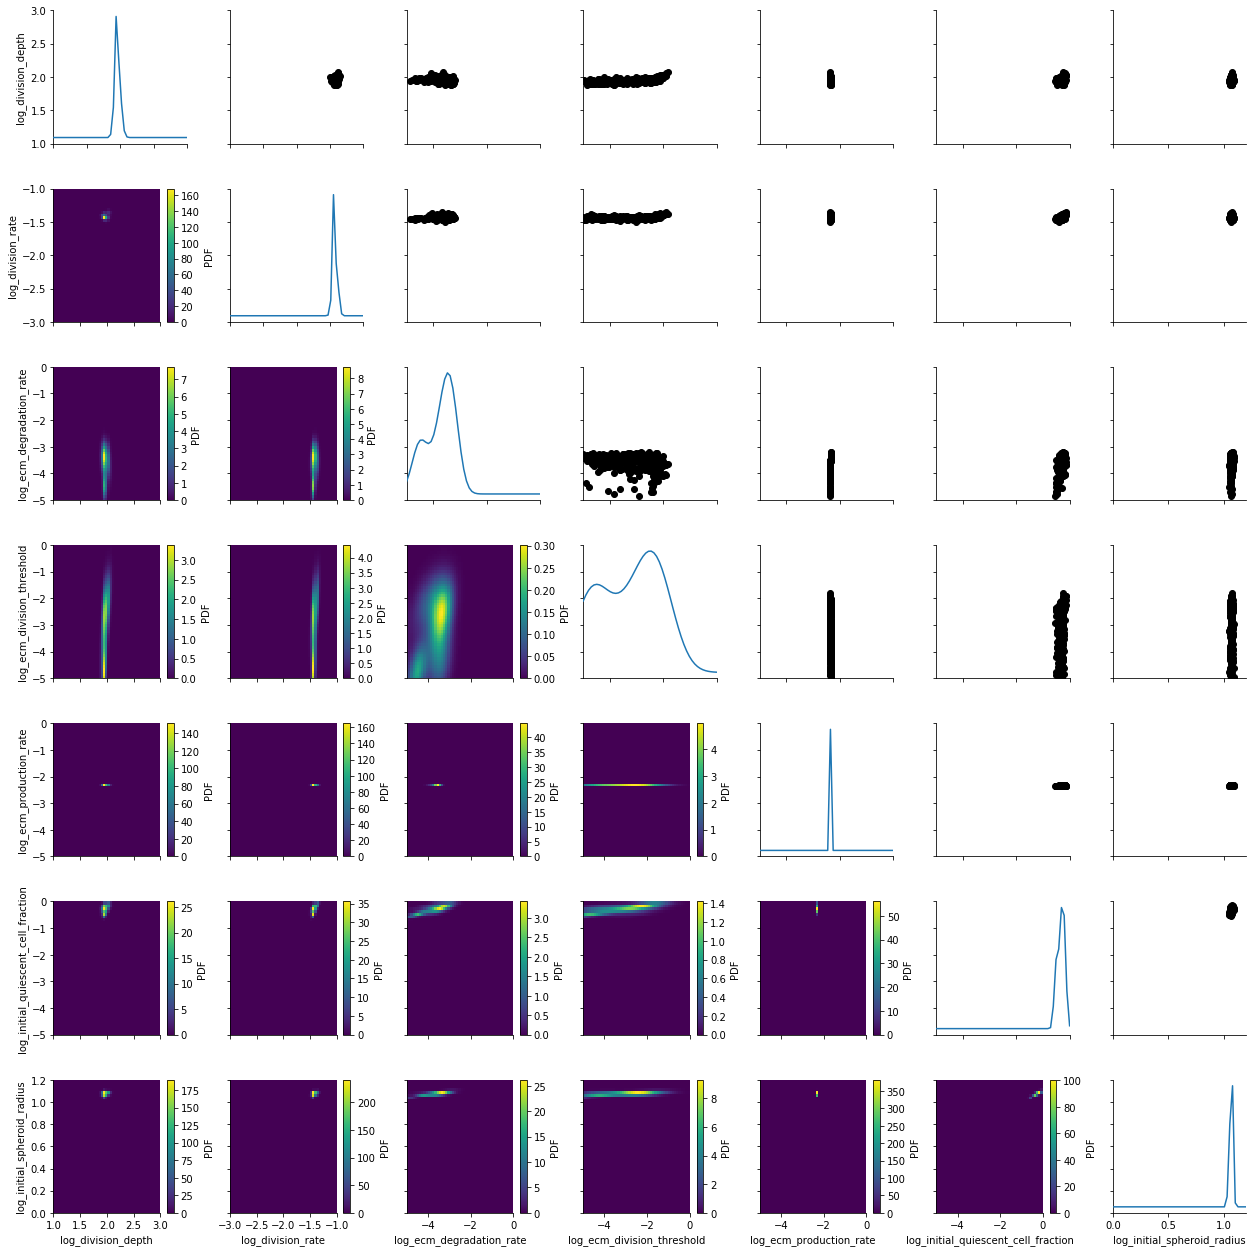

In [9]:
df, w = h_loaded.get_distribution(m=0)
plot_kde_matrix(df, w, limits=limits);

For this run, we employed one of pyABC's unique features: Adaptive population sizes.
We initialized with population size 500. pyABC tuned the necessary population size automatically.

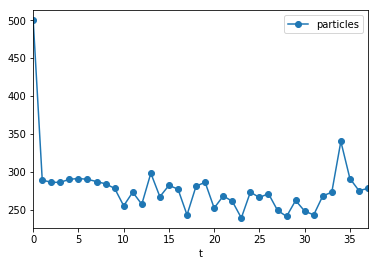

In [12]:
populations = h_loaded.get_all_populations()
(populations[populations.t >= 0]
 .plot("t", "particles", marker="o"));

In this example, the population size was roughly constant, however, this is not always the case.

The full executio of this notebook takes a little due to the tumor growth simulations performed:

In [13]:
print(f"Execution time: {(time() - start_time)/60:.1f}m")

Execution time: 13.6m


We also compiled an animted gif from the complete course of the generations.
Observe how the posterior slowly contracts:


![Complete generations](generations.gif)